In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pymc3 as pm
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import theano.tensor as tt
from scipy import stats

# Non-Markovian methods


## Grid search
Very much like the first assignment..

In [14]:
def posterior_grid(grid_points = 50, head = 6, tails = 9):
    """
    grid implementation for coin flipping
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points) #unif. prior
    likelihood = stats.binom.pmf(head, head + tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior
    

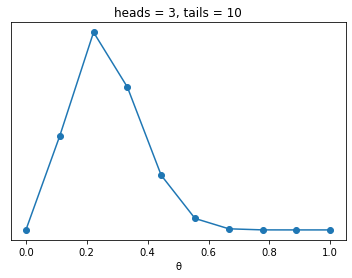

In [15]:
data = np.repeat([0, 1], (10, 3)) #flipping coin 13 times
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(grid_points = points, head = h, tails = t)
plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

### take-aways
Grid --> inifinity we get the exact posterior back (at expense of compute). <br/>
Computationally extremely heavy and scales terrible with dimension of parameter space <br/>

## Quadratic
find MAP (mode/mean same for Gaussian) and estimate curvature. <br/>
Computationally much cheaper than grid-approximation. <br/>
Used in frequentist methods but is also not applicable for complex models.

In [16]:
with pm.Model() as normal_approximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w', n = 1, p = p, observed = data)
    mean_q = pm.find_MAP() #find mode
    std_q = ((1/pm.find_hessian(mean_q, vars = [p])) ** 0.5)[0] #estimate curvature w. Hessian matrix.
mean_q['p'], std_q

(array(0.23076923), array([0.11685454]))

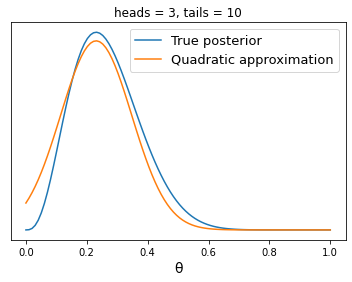

In [17]:
# analytic calculation
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, h+1, t+1),
        label = 'True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q), 
        label = 'Quadratic approximation')
plt.legend(loc = 0, fontsize = 13)

plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize = 14)
plt.yticks([]);

### take-aways
Notice that the quadratic approximation is tricky for cases of bounded data <br/>
The Gaussian will always reserve (some very small) prob. mass for [-infinity, infinity]. <br/>
In other words it is an unbounded distribution.

# Variational methods (still Non-Markovian)

For some problems Markovian methods are too slow. <br/>
Variational methods can be a solution is such cases. <br/>
Relies on approximating posterior with simpler distributions <br/>
Uses KL-DIV to find a good approximate function (or combination?). 

## Automatic diff. variational inference

# Markovian Methods

## Monte Carlo

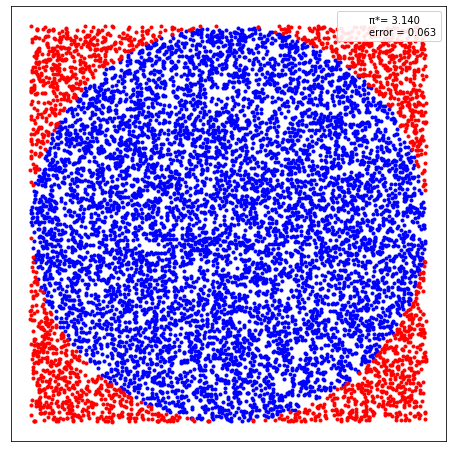

In [20]:
# estimating pi with monte carlo
N = 10000

x, y = np.random.uniform(-1, 1, size = (2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100

outside = np.invert(inside)

plt.figure(figsize = (8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label = f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha = 0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc = 1, frameon = True, framealpha = 0.9);

## Markov chain

Generally implemented as symmetric (detailed balance condition) <br/>
This means that the transition probability from a --> b = b --> a

## Metropolis-Hastings

Accept new sample if it has higher probability than current <br/>
If it has less probability then with probability proportional to ratio between new and current (old). <br/>
If we do not accept new we record the current (old) again.

In [21]:
# toy model to illustrate
def metropolis(func, draws = 10000):
    trace = np.zeros(draws)
    old_x = 0.5 # func.mean()
    old_prob = func.pdf(old_x)
    
    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random(): 
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else: 
            trace[i] = old_x
    return trace

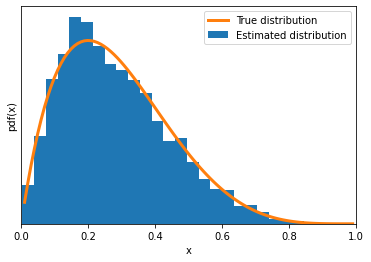

In [22]:
np.random.seed(3)
func = stats.beta(2, 5)
trace = metropolis(func = func)
x = np.linspace(0.01, 0.99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'C1-', lw = 3, label = 'True distribution')
plt.hist(trace[trace > 0], bins = 25, density = True, label = 'Estimated distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend();

NB: efficiency depends heavily on the nature of the target distribution (posterior). <br/>
Can be very inefficient for weird distributions..

## Hamiltonian Monte Carlo
critical difference between Hamiltonian monte carlo and Metropolis-Hastings: <br/>
The proposal of new positions is not random. <br/>
So.. we spend more time on getting each sample, but they are SO MUCH better that it is worth. <br/>
Achives much higher acceptance rate than metropolis-hastings because the proposals are much better.
Means that we need to compute $gradients$. NUTS is really good.
NUTS only works for continuous parameters (because we cannot compute gradient for non-continuous) <br/>
Thus pyMC3 assigns metropolis to non-continuous and NUTS to continuous parameters. 

## Sequential Monte Carlo

See Obsidian.

# Diagnosing the samples
### Things to try 
1. increase number of samples <br/>
2. remove samples from beginning (burn-in) <br/>
3. modify sampler parameters (tuning phase, target_accept) <br/>
4. re-parameterize the model <br/>
5. transform the data (e.g. centering and/or scaling).

Running models without data below..?

In [23]:
with pm.Model() as centered_model: 
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape = 10)
    trace_cm = pm.sample(2000, random_seed = 7)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)
    b_shift = pm.Normal('b_offset', mu = 0, sd = 1, shape = 10)
    b = pm.Deterministic('b', 0 + b_shift * a)
    trace_ncm = pm.sample(2000, random_seed = 7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7004020505232822, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6264688504156473, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_offset, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


## Convergence

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

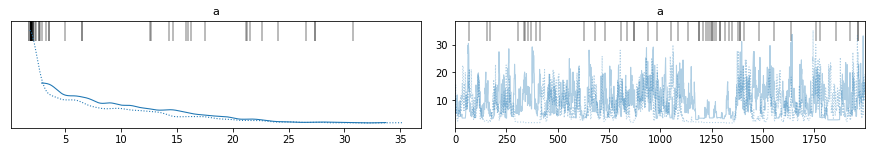

In [24]:
az.plot_trace(trace_cm, var_names = ['a'], divergences = 'top')

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

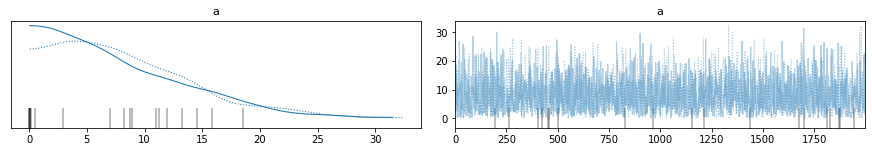

In [25]:
az.plot_trace(trace_ncm, var_names = 'a')

The latter model has "good mixing" (see right-side) and more smooth KDE (see left side). <br/>
A bad chain is not a problem in the limit but is for finite samples. <br/>
If the problem is not too bad we can fix it simply by taking more samples. <br/>
auto-similar trace is a good sign (first samples look like last samples). <br/>
We do not want patterns but white noise.

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

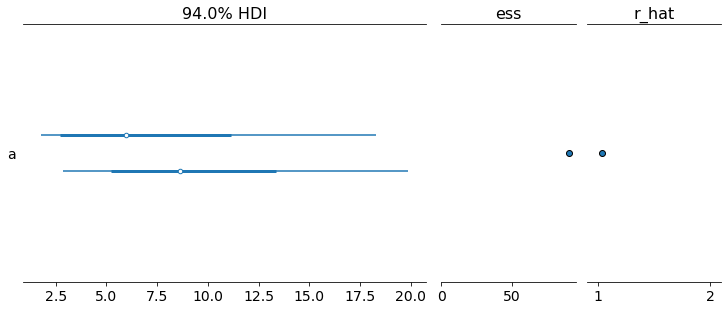

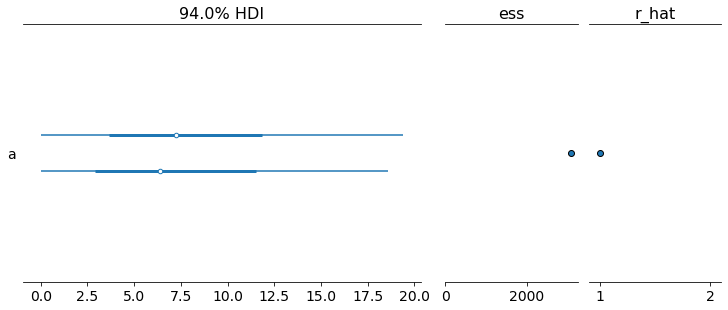

In [31]:
az.plot_forest(trace_cm, var_names = ['a'],
              r_hat = True, ess = True)
az.plot_forest(trace_ncm, var_names = ['a'],
              r_hat = True, ess = True)

In [32]:
summaries = pd.concat([az.summary(trace_cm, var_names = ['a']),
                      az.summary(trace_ncm, var_names = ['a'])])
summaries.index = ['centered', 'non-centered']
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centered,8.723,5.779,1.782,19.252,0.540,0.383,55.0,34.0,1.05
non-centered,8.059,5.945,0.019,18.967,0.107,0.075,2375.0,1415.0,1.00


## Monte Carlo error

## Autocorrelation

array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>], dtype=object)

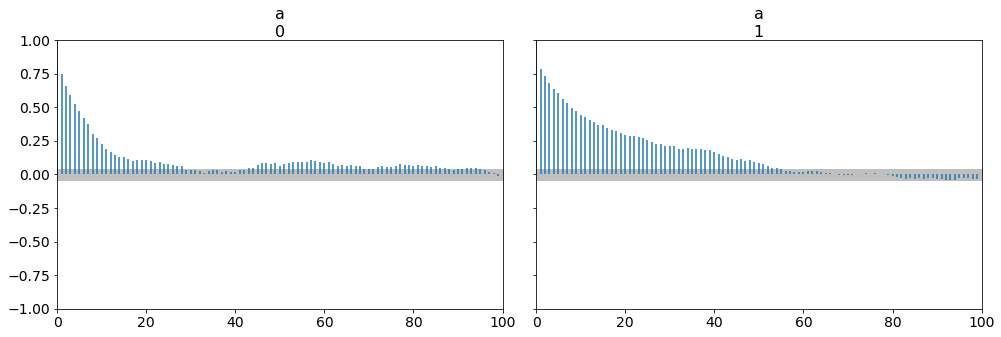

In [33]:
az.plot_autocorr(trace_cm, var_names = ['a'])

array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>], dtype=object)

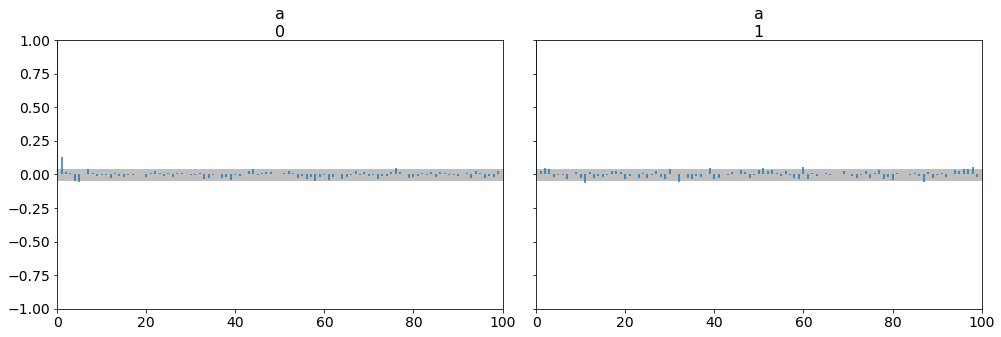

In [34]:
az.plot_autocorr(trace_ncm, var_names = ['a'])

## Effective sample size 
depends on auto-correlation. NUTS much better than Metropolis-Hastings.

## Divergences

/home/victormp/.local/lib/python3.9/site-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(
/home/victormp/.local/lib/python3.9/site-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


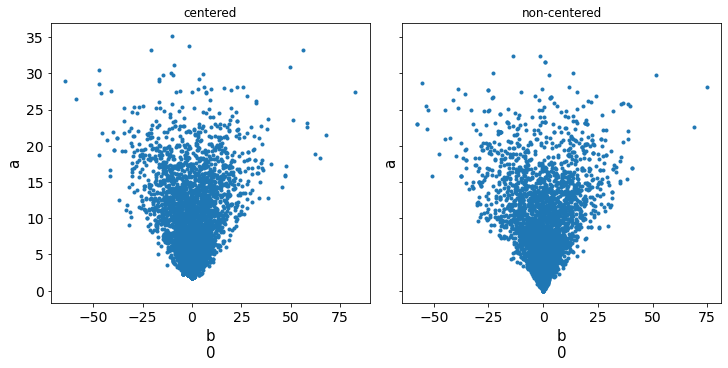

In [38]:
# don't actually get the divergences..
_, ax = plt.subplots(1, 2, sharey = True, figsize = (10, 5),
                     constrained_layout = True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names = ['b', 'a'], coords = {'b_dim_0': [0]},
                kind = 'scatter',
                divergences = True, #countour = False,
                divergences_kwargs = {'color': 'C1'},
                ax = ax[idx])
    
    ax[idx].set_title(['centered', 'non-centered'][idx])
plt.plot();

Investigating divergences more..

<AxesSubplot:>

/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


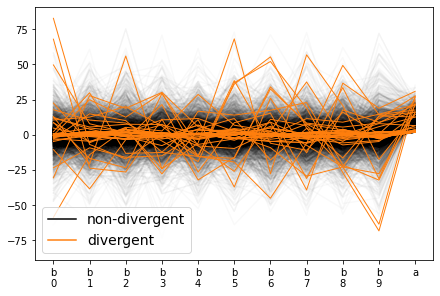

In [39]:
az.plot_parallel(trace_cm)

## Non-centered parameterization

# Exercises